# kNN - Experimento variando K y tamaño de imagenes


Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [ ]:
!cd .. && ./build.sh

## Explorando los datos

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_orig = pd.read_csv("../data/train.csv")
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [2]:
df_orig.sample(frac=1, random_state=2020)

def slice(n):
    df_train = df_orig.copy()[:n]
    X = df_train[df_train.columns[1:]].values
    y = df_train["label"].values.reshape(-1, 1)
    
    return X, y


### Experimento

In [3]:
import metnum
import pandas as pd

from scoring import metrics
from scoring import cross_validation as cv
from tqdm import tqdm

scoring_fns = {
    "accuracy":  metrics.accuracy_score,
    "recall":    metrics.recall_score,
    "precision": metrics.precision_score,
    "f1":        metrics.f1_score,
}

K_FOLD_VALUES = [2, 4, 6, 8, 10, 20]
X_SIZES = [500, 1000, 2500, 5000, 8000, 10000, 25000, 42000]
LABEL = "kNN_distance_pow"
#LABEL = "kNN_uniform+PCA"
#LABEL = "kNN_distance_pow+PCA"

rows = []
clf = metnum.KNNClassifier(4, "distance_pow")
for K in tqdm(K_FOLD_VALUES, "Ks"):
    for size in X_SIZES:
        X, y = slice(size)
        scores = cv.cross_validate_fns(clf, X, y, scoring_fns, K)

        # scores es un dict con las keys de scoring_fns, que son las
        # mismas que las columnas del dataframe.
        rows.append({
            **{
                "label": LABEL,
                "K": K,
                "sample_size": size,
            }, 
            **scores
        })

print("Creating DataFrame...")
df = pd.DataFrame(rows, columns=["label", "K", "sample_size", "accuracy", "recall", "precision", "f1"])

print("Finished!")

Ks: 100%|██████████| 6/6 [2:23:46<00:00, 1437.79s/it]

Creating DataFrame...
Finished!


In [ ]:
df.sort_values("accuracy", ascending=False)

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
plot = sns.scatterplot(
    data=df, x="k", y="accuracy", 
    hue="weight_type",
    legend="full",
)
plot.set_ylim(0.945, 0.98)

In [4]:
df.to_csv("data/knn/variaciones/knn_distance_pow.csv", index=False)

Text(0.5, 1.0, 'Accuracy para combinaciones de sample_size y K\n    (de K-Fold) en kNN con weights de distancia cubicos')

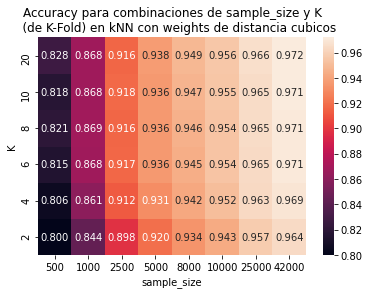

In [10]:
import seaborn as sns
df_pivot = df.pivot("K", "sample_size", "accuracy")
ax = sns.heatmap(data=df_pivot, annot=True, fmt=".3f")
ax.invert_yaxis()
ax.set_title(
    """Accuracy para combinaciones de sample_size y K
    (de K-Fold) en kNN con weights de distancia cubicos"""
)

In [ ]:
## concluimos que distance_pow es el mejor
## TODO: graficar cosas